# Calibration du modèle à volatilité stochastique de Taylor : Filtre

particulaire

Cheryl Kouadio  
2025-01-21

# Estimation du modèle SV de Taylor par filtrage particulaire (Part 2-a)

Le modèle classique de volatilité stochastique est défini par les
équations suivantes :

1.  **Processus des rendements** :

    $$ r_t = \exp(x_t / 2) \cdot \varepsilon_t, \quad \varepsilon_t \sim N(0,1) $$

2.  **Processus de la volatilité logarithmique** :

    $$ x_t = \mu + \phi x_{t-1} + \sigma_t \eta_t, \quad \eta_t \sim N(0,1) $$

-   ( x_t ) suit un processus autorégressif de premier ordre (**AR(1)**)
    et suit une distribution normale conditionnelle :
    $$ p(x_t) \sim N(\frac{\mu}{1-\phi} , \frac{\sigma_t^2}{1-\phi^2}) $$

    $$ x_t | x_{t-1} \sim N(\mu + \phi x_{t-1}, \sigma_t^2) $$

-   ( r_t ) suit une distribution **normale conditionnelle** :

    $$ r_t | x_t \sim N(0, \exp(x_t)) $$

In [ ]:
set.seed(123)  # Pour rendre les simulations reproductibles

# Simulation d'un modèle à vol stochastique de Taylor
n <- 252
mu <- -0.8
phi <- 0.9
sigma_squared <- 0.09

x <- numeric(n)  # Log-volatilité
r <- numeric(n)  # Rendements simulés

for (t in 1:n) {
  if (t == 1) {
    # Densité de transition stationnaire de x_t
    x[t] <- rnorm(1, mean = mu/(1-phi), sd = sqrt(sigma_squared / (1 - phi^2)))
  } else {
    # Évolution de l'état
    x[t] <- mu + phi *x[t-1] + sqrt(sigma_squared) * rnorm(1, mean = 0, sd = 1)
  }
  # Simulation des rendements
  r[t] <- exp(x[t] / 2) * rnorm(1, mean = 0, sd = 1)
}

# extraction dans fichier csv
write.csv(data.frame(r, x), "true_sv_taylor.csv", row.names = FALSE)

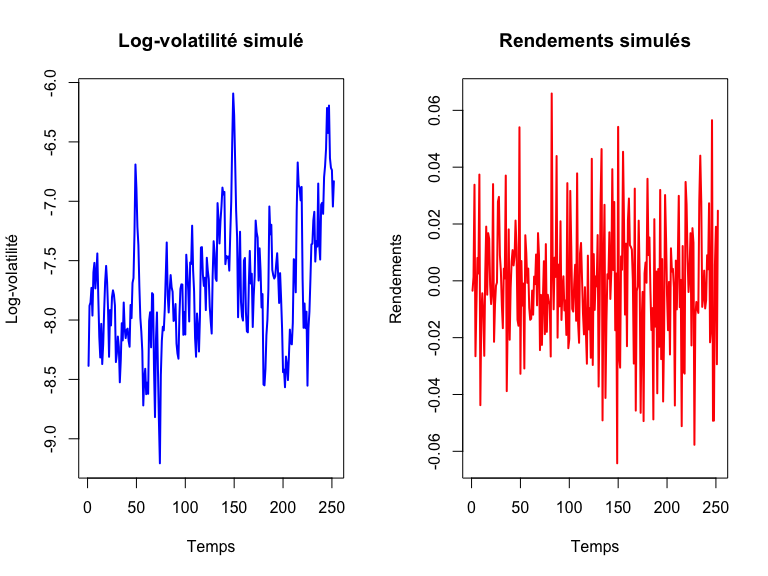

In [ ]:
par(mfrow=c(1,2))
plot(x, lwd = 2, type = "l", col = "blue", ylab = "Log-volatilité", xlab = "Temps", main = "Log-volatilité simulé")
plot(r, lwd = 2, type = "l", col = "red", ylab = "Rendements", xlab = "Temps", main = "Rendements simulés")

## Filtre bootstrap avec les rendements

In [ ]:
params <- c(mu,phi,sigma_squared)
params

[1] -0.80  0.90  0.09

In [ ]:
set.seed(123)  # Pour rendre les simulations reproductibles

# Define parameters (ensure they are properly initialized)
mu <- params[1]
phi <- params[2]
sigma_squared <- params[3]

# Definition des variables
# Définition des paramètres
n <- length(r)  # Nombre d'observations
M <- 10000      # Nombre de particules

# Initialisation des matrices et vecteurs
x_hat <- numeric(n)                   # Estimation de x
x_particle <- matrix(nrow = n, ncol = M)  # Particules
w <- matrix(nrow = n, ncol = M)        # Poids des particules
w_normalized <- matrix(nrow = n, ncol = M) # Poids normalisés

# Filtre particulaire bootstrap
for (t in 1:n) {
  if (t == 1) {
    # Initialisation des particules à t = 0
    x_particle[t, ] <- rnorm(M, mean = mu/(1-phi), sd = sqrt(sigma_squared / (1 - phi^2)))
    
    # Poids initiaux (basés sur la distribution de l'état initial)
    w[t, ] <- dnorm(x_particle[t, ], mean = mu/(1-phi), sd = sqrt(sigma_squared / (1 - phi^2)))
    
    # Normalisation des poids
    w_normalized[t, ] <- w[t, ] / sum(w[t, ])
    
    # Estimation initiale
    x_hat[t] <- sum(w_normalized[t, ] * x_particle[t, ])
  } else {
    #  Étape de prédiction (échantillonnage de nouvelles particules)
    x_particle[t, ] <- rnorm(M, mean = mu + phi * x_particle[t - 1, ], sd = sqrt(sigma_squared))
    
    #  Mise à jour des poids avec la vraisemblance de l'observation
    w[t, ] <- dnorm(r[t], mean = 0, sd = sqrt(exp(x_particle[t, ])))
    
    #  Normalisation des poids
    w_normalized[t, ] <- w[t, ] / sum(w[t, ])
    
    #  Rééchantillonnage des particules selon leurs poids
    index <- sample(1:M, size = M, prob = w_normalized[t, ], replace = TRUE)
    x_particle[t, ] <- x_particle[t, index]
    
    # Réinitialisation des poids après rééchantillonnage (uniforme)
    w_normalized[t, ] <- 1 / M
    
    #  Estimation de x à l'instant t (pondérée)
    x_hat[t] <- sum(w_normalized[t, ] * x_particle[t, ])
  }
}

In [ ]:
# Compute MSE
mse <- mean((x - x_hat)^2)
cat("MSE:", mse, "\n")

MSE: 0.2403607 

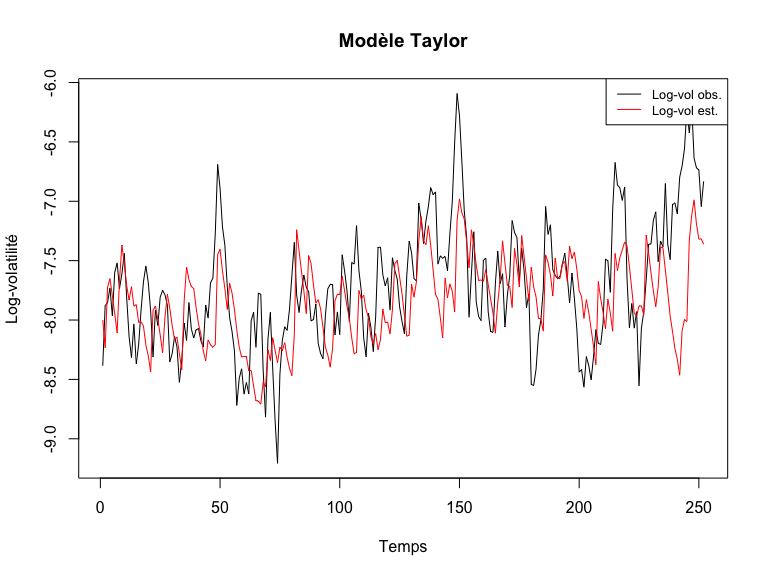

In [ ]:
plot(x, type = "l", col = "black", ylab = "Log-volatilité", xlab = "Temps", main = "Modèle Taylor")
lines(x_hat,  type = "l", col = "red", ylab = "Log-volatilité", xlab = "Temps")
legend("topright", legend=c("Log-vol obs.", "Log-vol est."), col=c("black", "red"), lty=1:1, cex=0.8)

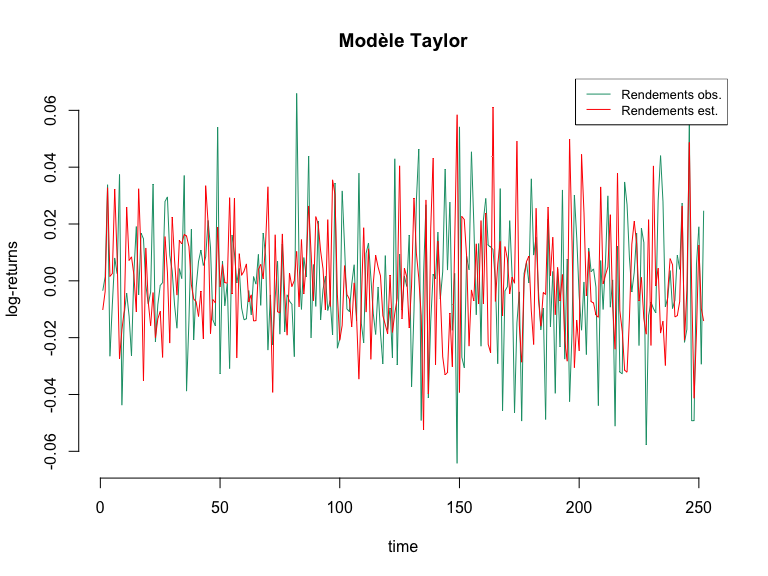

In [ ]:
set.seed(123)  # Pour rendre les simulations reproductibles

r_est <- exp(x_hat / 2) * rnorm(length(x_hat), mean = 0, sd = 1)

# Plot the estimate and the true state
plot(r, type="l", xlab="time", ylab="log-returns", bty="n",col="#1B9E77",main = "Modèle Taylor")

# Superposition des trajectoires
lines(r_est, type = "l", col = "red",  xlab = "Temps", ylab = "Rendements", bty="n")

# legend
legend("topright", legend=c("Rendements obs.", "Rendements est."), col=c("#1B9E77", "red"), lty=1:1, cex=0.8)

## Filtre bootstrap sur le modèle log-sv de taylor

In [ ]:
set.seed(123)  # Pour rendre les simulations reproductibles

y_hat <- numeric(n)
w_hat <- numeric(n)
x_particle <- matrix(nrow = n, ncol = M)
w <- matrix(nrow = n, ncol = M)
w_normalized <- matrix(nrow = n, ncol = M)
y <- log(r**2)

# Densité d'une log chi-deux de df 1
log_chi2 <- function(x) {
  density <- exp( (x/2) - exp(x/2))/sqrt(2*pi)
  return( density)
}


# Filtre particulaire bootstrap
for (t in 1:n) {
  if (t == 1) {
    # Initialisation des particules à t = 0
    x_particle[t, ] <- rnorm(M, mean = mu/(1-phi), sd = sqrt(sigma_squared / (1 - phi^2)))
    
    # Poids initiaux (basés sur la distribution de l'état initial)
    w[t, ] <- dnorm(x_particle[t, ], mean = mu/(1-phi), sd = sqrt(sigma_squared / (1 - phi^2)))
    
    # Normalisation des poids
    w_normalized[t, ] <- w[t, ] / sum(w[t, ])
    
    # Estimation initiale
    x_hat[t] <- sum(w_normalized[t, ] * x_particle[t, ])
  } else {
    #  Étape de prédiction (échantillonnage de nouvelles particules)
    x_particle[t, ] <- rnorm(M, mean = mu + phi * x_particle[t - 1, ], sd = sqrt(sigma_squared))
    
    #  Mise à jour des poids avec la vraisemblance de l'observation
    w[t, ] <- log_chi2(y[t] - x_particle[t,])
    
    #  Normalisation des poids
    w_normalized[t,] <- w[t,] / sum(w[t,])
    
    #  Rééchantillonnage des particules selon leurs poids
    index <- sample(1:M, size = M, prob = w_normalized[t, ], replace = TRUE)
    x_particle[t, ] <- x_particle[t, index]
    
    # Réinitialisation des poids après rééchantillonnage (uniforme)
    w_normalized[t, ] <- 1 / M
    
    #  Estimation de x à l'instant t (pondérée)
    x_hat[t] <- sum(w_normalized[t, ] * x_particle[t, ])
  }
}

In [ ]:
# Compute MSE
mse <- mean((x - x_hat)^2)
cat("MSE:", mse, "\n")

MSE: 0.3450866 

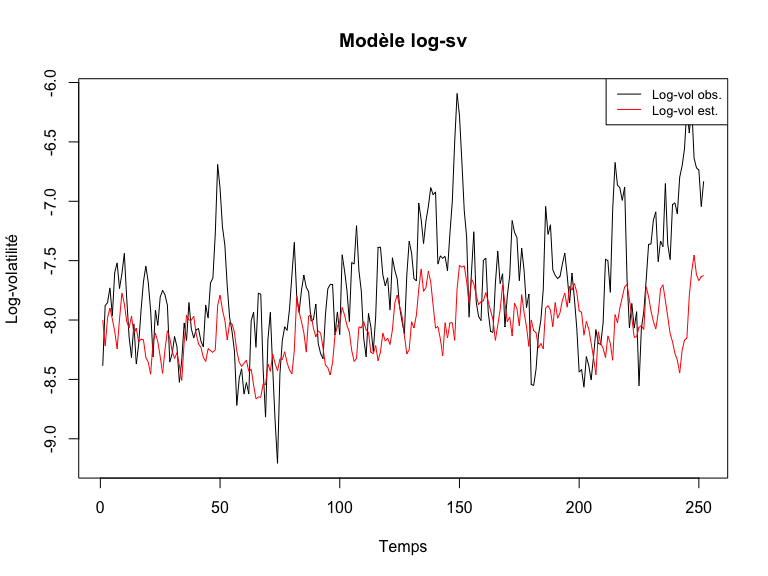

In [ ]:
plot(x, type = "l", col = "black", ylab = "Log-volatilité", xlab = "Temps", main = "Modèle log-sv")
lines(x_hat,  type = "l", col = "red", ylab = "Log-volatilité", xlab = "Temps")
legend("topright", legend=c("Log-vol obs.", "Log-vol est."), col=c("black", "red"), lty=1:1, cex=0.8)

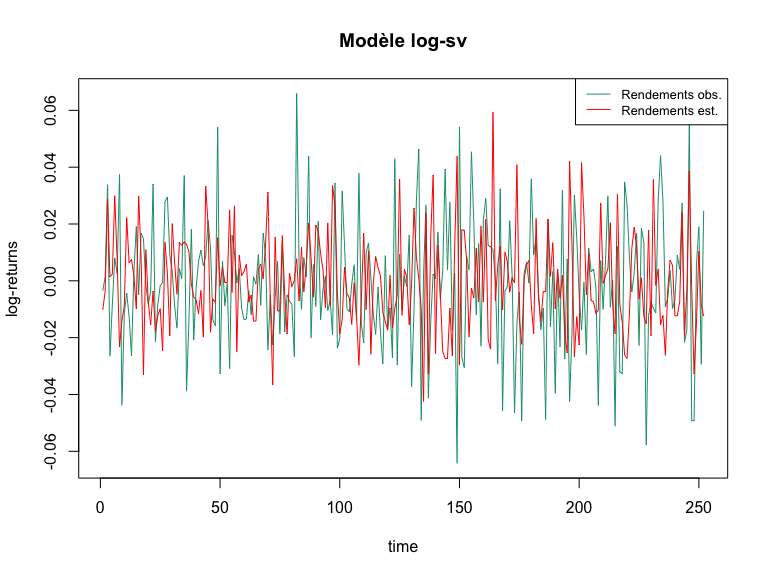

In [ ]:
set.seed(123)  # Pour rendre les simulations reproductibles

r_est <- exp(x_hat / 2) * rnorm(length(x_hat), mean = 0, sd = 1)

# Plot the estimate and the true state
plot(r, type="l", xlab="time", ylab="log-returns", col="#1B9E77", main = "Modèle log-sv")

# Superposition des trajectoires
lines(r_est, type = "l", col = "red",  xlab = "Temps", ylab = "Rendements")

# legend
legend("topright", legend=c("Rendements obs.", "Rendements est."), col=c("#1B9E77", "red"), lty=1:1, cex=0.8)

# Estimation du modèle SV de Taylor par filtrage particulaire (Version pmhtutorial - Part 2-b)

Le modèle de volatilité stochastique modifié est défini par les
équations suivantes :

1.  **Processus des rendements** :

    $$ r_t = \exp(x_t / 2) \cdot \varepsilon_t, \quad \varepsilon_t \sim N(0,1) $$

2.  **Processus de la volatilité logarithmique** :

    $$ x_t = \mu + \phi \times (x_{t-1}-\mu) + \sigma_t \eta_t, \quad \eta_t \sim N(0,1) $$

-   ( x_t ) suit un processus autorégressif de premier ordre (**AR(1)**)
    et suit une distribution normale conditionnelle :
    $$ p(x_t) \sim N(\mu , \frac{\sigma_t^2}{1-\phi^2}) $$
    $$ x_t | x_{t-1} \sim N(\mu + \phi \times (x_{t-1}-\mu) , \sigma_t^2) $$

-   ( r_t ) suit une distribution **normale conditionnelle** :

    $$ r_t | x_t \sim N(0, \exp(x_t)) $$
    $r_t = exp(x_t/2)* \varepsilon_t$ $\varepsilon_t$ ~ N(0,1)
    $x_t = \mu + \phi * (x_{t-1} - \mu) + \sigma_t * \eta_t$ (eta_t ~
    N(0,1))

In [ ]:
rm(list = ls())

In [ ]:
set.seed(123)  # Pour rendre les simulations reproductibles
n <- 252
mu <- -0.8
phi <- 0.9
sigma_squared <- 0.09

# Simulation d'un modèle à vol stochastique de Taylor (modifié)
x <- numeric(n)  # Log-volatilité
r <- numeric(n)  # Rendements simulés

for (t in 1:n) {
  if (t == 1) {
    # Densité de transition stationnaire de x_t
    x[t] <- rnorm(1, mean = mu, sd = sqrt(sigma_squared / (1 - phi^2)))
  } else {
    # Évolution de l'état
    #    x[t] <- mu + phi * (x[t-1]) + sqrt(sigma_squared) * rnorm(1, mean = 0, sd = 1)
    #                       ^^^^^^ True model. To be able to use pmhtutorial package, use the following formula
    x[t] <- mu + phi * (x[t-1] - mu) + sqrt(sigma_squared) * rnorm(1, mean = 0, sd = 1)
  }
  # Simulation des rendements
  r[t] <- exp(x[t] / 2) * rnorm(1, mean = 0, sd = 1)
}

# extraction dans fichier csv
write.csv(data.frame(r, x), "mod_log_sv.csv", row.names = FALSE)

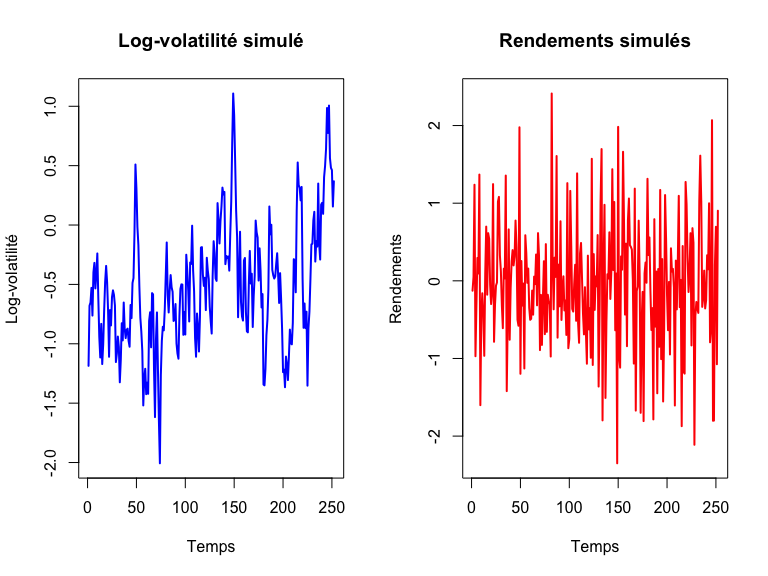

In [ ]:
par(mfrow=c(1,2))
plot(x, lwd = 2, type = "l", col = "blue", ylab = "Log-volatilité", xlab = "Temps", main = "Log-volatilité simulé")
plot(r, lwd = 2, type = "l", col = "red", ylab = "Rendements", xlab = "Temps", main = "Rendements simulés")

## Filtre bootstrap avec les rendements

In [ ]:
set.seed(123)  # Pour rendre les simulations reproductibles

# Definition des variables
# Définition des paramètres

params <- c(mu,phi,sigma_squared)

n <- length(r)  # Nombre d'observations
M <- 10000      # Nombre de particules

# Initialisation des matrices et vecteurs
x_hat <- numeric(n)                   # Estimation de x
x_particle <- matrix(nrow = n, ncol = M)  # Particules
w <- matrix(nrow = n, ncol = M)        # Poids des particules
w_normalized <- matrix(nrow = n, ncol = M) # Poids normalisés

# Filtre particulaire bootstrap
for (t in 1:n) {
  if (t == 1) {
    # Initialisation des particules à t = 0
    x_particle[t, ] <- rnorm(M, mean = mu, sd = sqrt(sigma_squared / (1 - phi^2)))
    
    # Poids initiaux (basés sur la distribution de l'état initial)
    w[t, ] <- dnorm(x_particle[t, ], mean = mu, sd = sqrt(sigma_squared / (1 - phi^2)))
    
    # Normalisation des poids
    w_normalized[t, ] <- w[t, ] / sum(w[t, ])
    
    # Estimation initiale
    x_hat[t] <- sum(w_normalized[t, ] * x_particle[t, ])
  } else {
    #  Étape de prédiction (échantillonnage de nouvelles particules)
    x_particle[t,] <- rnorm(M, mean = mu + phi * (x_particle[t - 1, ] - mu), sd = sqrt(sigma_squared))
    
    #  Mise à jour des poids avec la vraisemblance de l'observation
    w[t, ] <- dnorm(r[t], mean = 0, sd = sqrt(exp(x_particle[t, ])))
    
    #  Normalisation des poids
    w_normalized[t, ] <- w[t, ] / sum(w[t, ])
    
    #  Rééchantillonnage des particules selon leurs poids
    index <- sample(1:M, size = M, prob = w_normalized[t, ], replace = TRUE)
    x_particle[t, ] <- x_particle[t, index]
    
    # Réinitialisation des poids après rééchantillonnage (uniforme)
    w_normalized[t, ] <- 1 / M
    
    #  Estimation de x à l'instant t (pondérée)
    x_hat[t] <- sum(w_normalized[t, ] * x_particle[t, ])
  }
}

In [ ]:
# Compute MSE
mse <- mean((x - x_hat)^2)
cat("MSE:", mse, "\n")

MSE: 0.2403607 

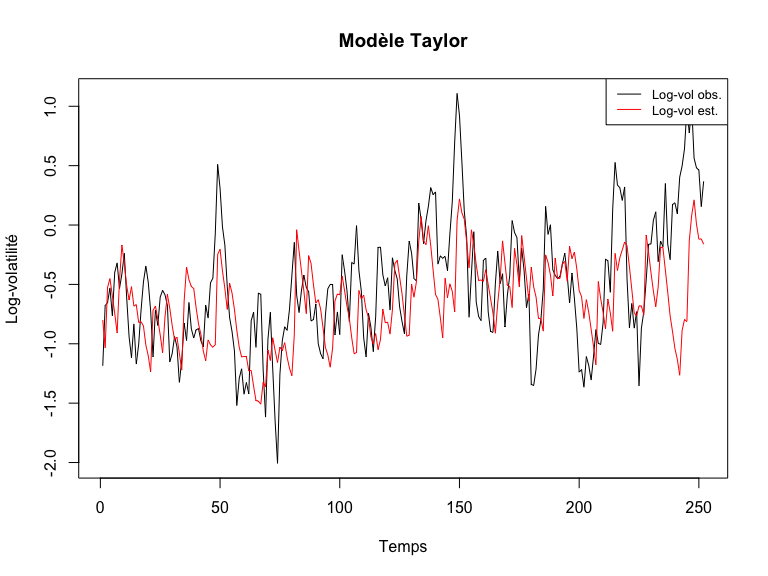

In [ ]:
plot(x, type = "l", col = "black", ylab = "Log-volatilité", xlab = "Temps", main = "Modèle Taylor")
lines(x_hat,  type = "l", col = "red", ylab = "Log-volatilité", xlab = "Temps")
legend("topright", legend=c("Log-vol obs.", "Log-vol est."), col=c("black", "red"), lty=1:1, cex=0.8)

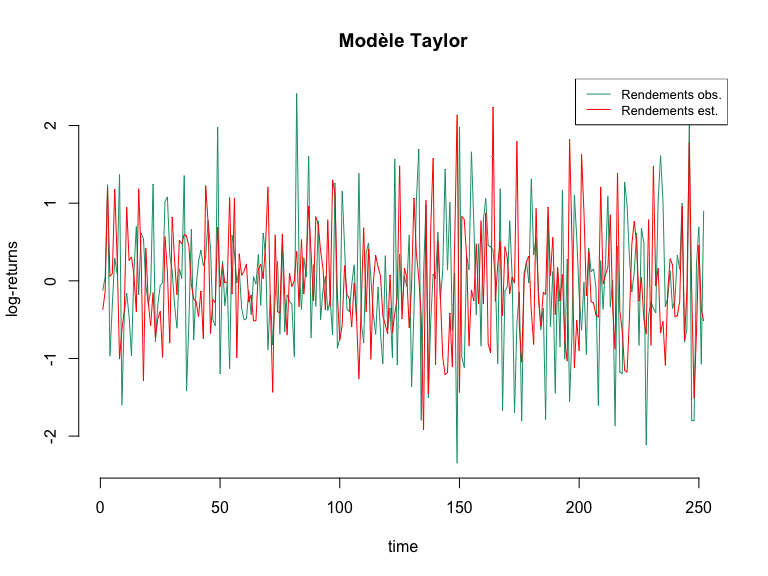

In [ ]:
set.seed(123)  # Pour rendre les simulations reproductibles

r_est <- exp(x_hat / 2) * rnorm(length(x_hat), mean = 0, sd = 1)

# Plot the estimate and the true state
plot(r, type="l", xlab="time", ylab="log-returns", bty="n",col="#1B9E77",main = "Modèle Taylor")

# Superposition des trajectoires
lines(r_est, type = "l", col = "red",  xlab = "Temps", ylab = "Rendements", bty="n")

# legend
legend("topright", legend=c("Rendements obs.", "Rendements est."), col=c("#1B9E77", "red"), lty=1:1, cex=0.8)

### Utilisation de library(pmhtutorial)

In [ ]:
library(pmhtutorial)

# particleFilterSVmodel takes sigma as parameters
params[3] <- sqrt(params[3])
x_hat_2<- particleFilterSVmodel(r,params,M)

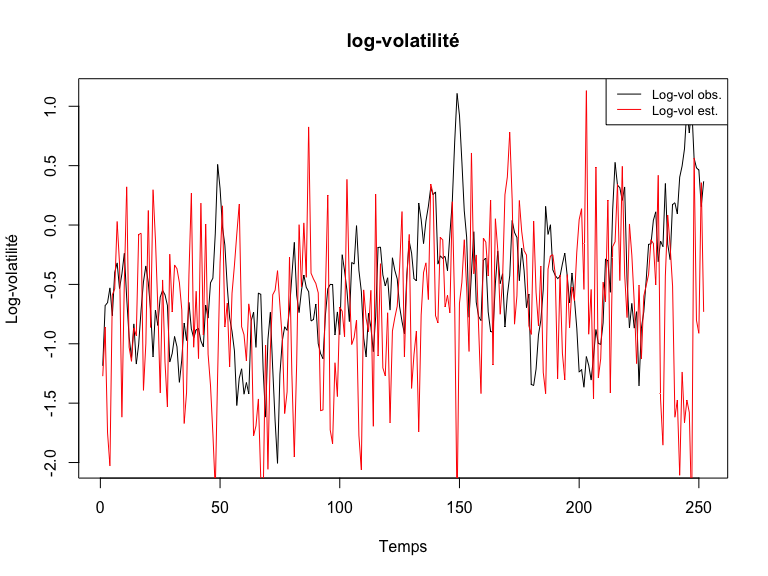

In [ ]:
plot(x, type = "l", col = "black", ylab = "Log-volatilité", xlab = "Temps", main = "log-volatilité")
lines(x_hat_2$xHatFiltered, type = "l", col = "red", ylab = "Log-volatilité", xlab = "Temps", main = "Log-volatilité estimé")
# legend
legend("topright", legend=c("Log-vol obs.", "Log-vol est."), col=c("black", "red"), lty=1:1, cex=0.8)

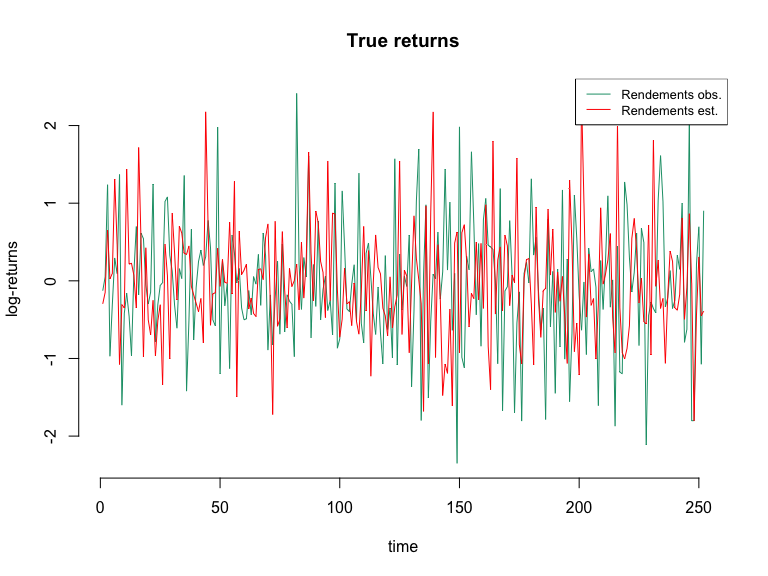

In [ ]:
set.seed(123)  # Pour rendre les simulations reproductibles

r_est <- exp(x_hat_2$xHatFiltered / 2) * rnorm(length(x_hat_2$xHatFiltered), mean = 0, sd = 1)

# Superposition des trajectoires
plot(r, type="l", xlab="time", ylab="log-returns", bty="n",
  col="#1B9E77", main="True returns")

lines(r_est, type = "l", col = "red",  xlab = "Temps", ylab = "Rendements", 
     main = "Estimated returns",bty="n")

legend("topright", legend=c("Rendements obs.", "Rendements est."), col=c("#1B9E77", "red"), lty=1:1, cex=0.8)

## Filtre bootstrap sur le modèle log-sv de taylor

In [ ]:
set.seed(123)  # Pour rendre les simulations reproductibles

params <- c(mu,phi,sigma_squared)

y_hat <- numeric(n)
w_hat <- numeric(n)
x_particle <- matrix(nrow = n, ncol = M)
w <- matrix(nrow = n, ncol = M)
w_normalized <- matrix(nrow = n, ncol = M)
y <- log(r**2)

# Densité d'une log chi-deux de df 1
log_chi2 <- function(x) {
  density <- exp( (x/2) - exp(x/2))/sqrt(2*pi)
  return( density)
}

# Filtre particulaire bootstrap
for (t in 1:n) {
  if (t == 1) {
    # Initialisation des particules à t = 0
    x_particle[t, ] <- rnorm(M, mean = mu, sd = sqrt(sigma_squared / (1 - phi^2)))
    
    # Poids initiaux (basés sur la distribution de l'état initial)
    w[t, ] <- dnorm(x_particle[t, ], mean = mu, sd = sqrt(sigma_squared / (1 - phi^2)))
    
    # Normalisation des poids
    w_normalized[t, ] <- w[t, ] / sum(w[t, ])
    
    # Estimation initiale
    x_hat[t] <- sum(w_normalized[t, ] * x_particle[t, ])
  } else {
    #  Étape de prédiction (échantillonnage de nouvelles particules)
    x_particle[t, ] <- rnorm(M, mean = mu + phi * (x_particle[t - 1, ]-mu), sd = sqrt(sigma_squared))
    
    #  Mise à jour des poids avec la vraisemblance de l'observation
    w[t, ] <- log_chi2(y[t] - x_particle[t,])
    
    #  Normalisation des poids
    w_normalized[t,] <- w[t,] / sum(w[t,])
    
    #  Rééchantillonnage des particules selon leurs poids
    index <- sample(1:M, size = M, prob = w_normalized[t, ], replace = TRUE)
    x_particle[t, ] <- x_particle[t, index]
    
    # Réinitialisation des poids après rééchantillonnage (uniforme)
    w_normalized[t, ] <- 1 / M
    
    #  Estimation de x à l'instant t (pondérée)
    x_hat[t] <- sum(w_normalized[t, ] * x_particle[t, ])
  }
}

In [ ]:
# Compute MSE
mse <- mean((x - x_hat)^2)
cat("MSE:", mse, "\n")

MSE: 0.3450866 

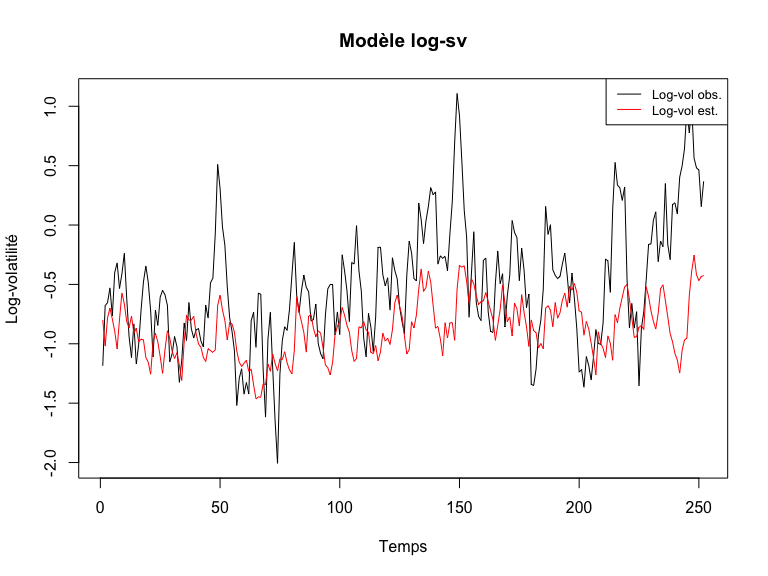

In [ ]:
plot(x, type = "l", col = "black", ylab = "Log-volatilité", xlab = "Temps", main = "Modèle log-sv")
lines(x_hat,  type = "l", col = "red", ylab = "Log-volatilité", xlab = "Temps")
legend("topright", legend=c("Log-vol obs.", "Log-vol est."), col=c("black", "red"), lty=1:1, cex=0.8)

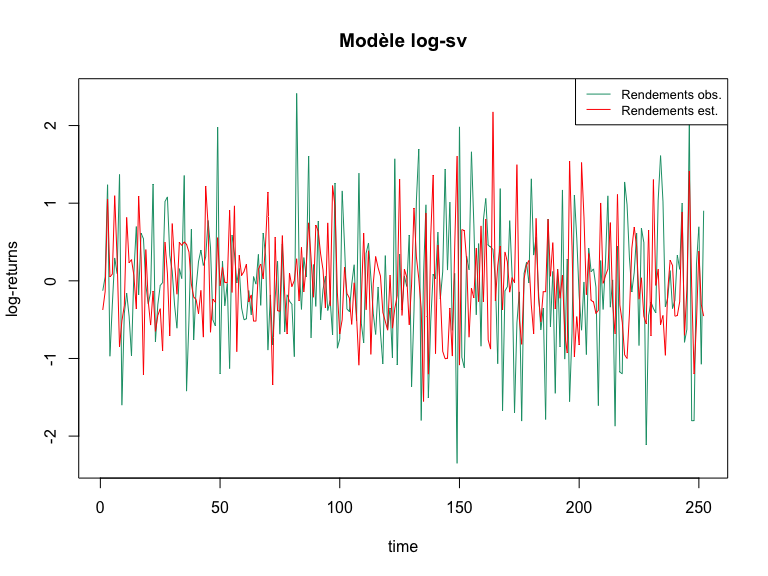

In [ ]:
set.seed(123)  # Pour rendre les simulations reproductibles

r_est <- exp(x_hat / 2) * rnorm(length(x_hat), mean = 0, sd = 1)

# Plot the estimate and the true state
plot(r, type="l", xlab="time", ylab="log-returns", col="#1B9E77", main = "Modèle log-sv")

# Superposition des trajectoires
lines(r_est, type = "l", col = "red",  xlab = "Temps", ylab = "Rendements")

# legend
legend("topright", legend=c("Rendements obs.", "Rendements est."), col=c("#1B9E77", "red"), lty=1:1, cex=0.8)

# Application sur données réelles

[1] "IXIC"

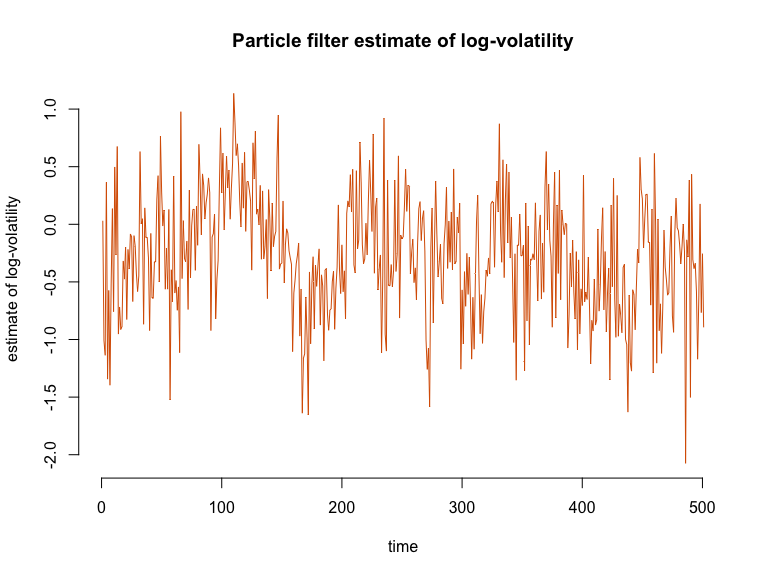

In [ ]:
# Get the data from Quandl
library(quantmod)

# Téléchargement des données de Yahoo Finance
getSymbols("^IXIC", src = "yahoo", from = "2012-01-02", to = "2014-01-02")

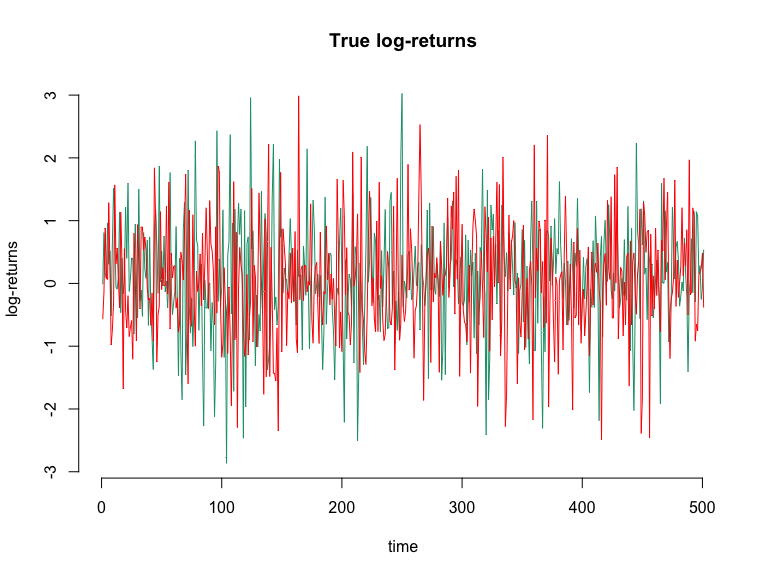

In [ ]:
# Simulation des rendements estimés à partir de x_hat
set.seed(123)  # Pour rendre les simulations reproductibles
r_est <- exp(pfOutput$xHatFiltered / 2) * rnorm(length(pfOutput$xHatFiltered), mean = 0, sd = 1)

# Superposition des trajectoires
plot(y, type="l", xlab="time", ylab="log-returns", bty="n",
  col="#1B9E77", main="True log-returns")

lines(r_est, type = "l", col = "red",  xlab = "Temps", ylab = "Rendements", 
     main = "Estimated log-returns",bty="n")